## Project: Decision Tracker
## Making informed decisions based on personal data
**Source:** Own files

### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [1]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath('/'))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [2]:
import requests # to download data from api
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pathlib # for path functions
import numpy as np

import sqlite3
import seaborn as sns

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

In [3]:
# PARAMETERS
plt.style.use('fivethirtyeight')

In [4]:
DataFolderPath = pathlib.Path(os.path.dirname(os.path.realpath(''))).parent
print(DataFolderPath)

C:\Users\tgusc\Documents\GitHub


In [5]:
filename = 'Wydatki_2021.xlsx'
file = os.path.join(DataFolderPath, 'Private', filename)

In [6]:
# wczytujemy excel bez dokładnej specyfikacji typów
wydatki = pd.read_excel(file, sheet_name='Wydatki', decimal=',')

wydatki["LP"] = wydatki["LP"].astype(np.int32)
wydatki["Nr koszyka"] = wydatki["Nr koszyka"].astype(str)
wydatki["Rok"] = wydatki["Rok"].astype(np.int32)
wydatki["Miesiac"] = wydatki["Miesiac"].astype(np.int32)
wydatki["Data"] = pd.to_datetime(wydatki["Data"])
wydatki["Cena"] = wydatki["Cena"].replace(',','.').astype(float)


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [7]:
# wczytujemy excel bez dokładnej specyfikacji typów
wydatki_wspolne = pd.read_excel(file, sheet_name='Wydatki_KontoWspolne', decimal=',')

wydatki_wspolne["LP"] = wydatki_wspolne["LP"].astype(np.int32)
wydatki_wspolne["Rok"] = wydatki_wspolne["Rok"].astype(np.int32)
wydatki_wspolne["Miesiac"] = wydatki_wspolne["Miesiac"].astype(np.int32)
wydatki_wspolne["Data"] = pd.to_datetime(wydatki_wspolne["Data"])
wydatki_wspolne["Cena"] = wydatki_wspolne["Cena"].replace(',','.').astype(float)

print(wydatki_wspolne.tail())

        LP Data Przedmiot  Cena Waluta Sklep  Kto Potrzeba Kategoria Grupa  \
1190  1191  NaT       NaN   NaN    NaN   NaN  NaN      NaN       NaN   NaN   
1191  1192  NaT       NaN   NaN    NaN   NaN  NaN      NaN       NaN   NaN   
1192  1193  NaT       NaN   NaN    NaN   NaN  NaN      NaN       NaN   NaN   
1193  1194  NaT       NaN   NaN    NaN   NaN  NaN      NaN       NaN   NaN   
1194  1195  NaT       NaN   NaN    NaN   NaN  NaN      NaN       NaN   NaN   

       Rok  Miesiac Rodzaj Komentarz  
1190  1900        1  Debit       NaN  
1191  1900        1  Debit       NaN  
1192  1900        1  Debit       NaN  
1193  1900        1  Debit       NaN  
1194  1900        1  Debit       NaN  


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [8]:
wydatki2 = wydatki[["Cena", "Rok", "Miesiac", "Rodzaj", "Kategoria"]].groupby(["Rok","Miesiac","Rodzaj", "Kategoria"]).sum().reset_index()
print(wydatki2)

       Rok  Miesiac Rodzaj                                   Kategoria  \
0     2019       11  Debit                                     Alkohol   
1     2019       11  Debit                        Czynsz za mieszkanie   
2     2019       11  Debit                              Dowolne zakupy   
3     2019       11  Debit                 Higiena, kosmetyki, fryzjer   
4     2019       11  Debit                          Hobby, kino, teatr   
...    ...      ...    ...                                         ...   
1051  2023        9  Debit  Rachunek telefoniczny i opłaty za internet   
1052  2023        9  Debit                     Rozrywka i przyjemności   
1053  2023        9  Debit                                   Transport   
1054  2023        9  Debit                      Wspólny rachunek - Ada   
1055  2023        9  Debit              Własny rozwój (kursy, zajęcia)   

         Cena  
0     -120.86  
1     -517.74  
2       -0.45  
3       -6.99  
4      -29.70  
...       ...  

In [9]:
wydatki2["Rok_msc"] = wydatki2["Rok"].astype(str) + "-" + wydatki2["Miesiac"].astype(str)
print(wydatki2.head())

    Rok  Miesiac Rodzaj                    Kategoria    Cena  Rok_msc
0  2019       11  Debit                      Alkohol -120.86  2019-11
1  2019       11  Debit         Czynsz za mieszkanie -517.74  2019-11
2  2019       11  Debit               Dowolne zakupy   -0.45  2019-11
3  2019       11  Debit  Higiena, kosmetyki, fryzjer   -6.99  2019-11
4  2019       11  Debit           Hobby, kino, teatr  -29.70  2019-11


In [10]:
species = wydatki2["Rok_msc"].value_counts().index
print(species)

Index(['2022-12', '2020-10', '2020-8', '2019-12', '2020-9', '2021-7', '2021-4',
       '2020-6', '2021-6', '2022-3', '2023-7', '2022-10', '2022-5', '2020-7',
       '2022-2', '2022-7', '2021-5', '2022-11', '2020-1', '2021-9', '2022-1',
       '2021-10', '2021-8', '2020-12', '2020-5', '2020-2', '2021-12', '2021-1',
       '2021-11', '2020-3', '2021-3', '2021-2', '2023-4', '2023-3', '2022-6',
       '2022-9', '2023-1', '2023-2', '2022-8', '2020-4', '2020-11', '2022-4',
       '2023-8', '2023-9', '2023-6', '2023-5', '2019-11'],
      dtype='object', name='Rok_msc')


In [11]:
wydatki.head()

,LP,Data,Przedmiot,Cena,Waluta,Sklep,Miejsce,Nr koszyka,Skad,Potrzeba,Kategoria,Grupa,Rok,Miesiac,Rodzaj,Komentarz
0,1,2019-11-24,Americano Duża,-13.50,PLN,Starbucks,Warszawa Plac Bankowy,1.0,Citi Kredytowa,Potrzeba,Jedzenie i picie: na mieście,Grupa IV,2019,11,Debit,NaN
1,2,2019-11-24,Espresso Doppio,-9.50,PLN,Starbucks,Warszawa Plac Bankowy,1.0,Citi Kredytowa,Potrzeba,Jedzenie i picie: na mieście,Grupa IV,2019,11,Debit,NaN
2,3,2019-11-24,Kawa,-12.00,PLN,Cafe Centrum,Warszawa Centrum,2.0,Citi Kredytowa,Zachcianka,Jedzenie i picie: zamawiane,Grupa IV,2019,11,Debit,NaN
3,4,2019-11-24,Wino grzane,-14.00,PLN,Cafe Centrum,Warszawa Centrum,2.0,Citi Kredytowa,Zachcianka,Alkohol,Grupa IV,2019,11,Debit,NaN
4,5,2019-11-25,"Cukinia luz 0,6kg",-5.39,PLN,Społem WSS Wola,Warszawa Ciołka,3.0,Mbank Debetowa,Potrzeba,Jedzenie i picie,Grupa I,2019,11,Debit,NaN


In [12]:
df = wydatki

# 2. Stworzenie lokalnej bazy danych SQLite
conn = sqlite3.connect('transactions_db.sqlite')
df.to_sql('transactions', conn, if_exists='replace', index=False)
conn.commit()

# Przygotowanie agregacji danych
query_sum = "SELECT Rok, Miesiac, Rodzaj, Kategoria, SUM(Cena) AS Suma FROM transactions GROUP BY Rok, Miesiac, Kategoria, Rodzaj"
monthly_data = pd.read_sql(query_sum, conn)


# 3. Przygotowanie agregacji danych
# Miesięczne wpływy
query_monthly_income = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wplywy FROM transactions WHERE Rodzaj = 'Credit' GROUP BY Rok, Miesiac, Kategoria"
monthly_income_by_type = pd.read_sql(query_monthly_income, conn)

# Miesięczne wydatki
query_monthly_expenses = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki FROM transactions WHERE Rodzaj = 'Debit' GROUP BY Rok, Miesiac, Kategoria"
monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Miesięczne przepływy
query_monthly_flow = "SELECT Rok, Miesiac, SUM(Case When Rodzaj = 'Credit' THEN Cena ELSE 0 END) as Wplywy, SUM(Case When Rodzaj = 'Debit' THEN Cena ELSE 0 END) as Wydatki FROM transactions GROUP BY Rok, Miesiac"
monthly_flow = pd.read_sql(query_monthly_flow, conn)
monthly_flow["Przeplywy"] = monthly_flow["Wplywy"] + monthly_flow["Wydatki"]

# Analiza miesięcznej struktury wydatków
monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# 4. Przygotowanie danych kumulatywnych
# Kumulacyjne wpływy
monthly_income_by_type['Kumulacyjne_Wplywy'] = monthly_income_by_type.groupby(['Rok', 'Kategoria'])['Wplywy'].cumsum()

# Kumulacyjne wydatki
monthly_expenses_by_type['Kumulacyjne_Wydatki'] = monthly_expenses_by_type.groupby(['Rok', 'Kategoria'])['Wydatki'].cumsum()

# Kumulacyjne przepływy
monthly_flow['Kumulacyjne_Wplywy'] = monthly_flow.groupby('Rok')['Wplywy'].cumsum()
monthly_flow['Kumulacyjne_Wydatki'] = monthly_flow.groupby('Rok')['Wydatki'].cumsum()
monthly_flow['Kumulacyjne_Przeplywy'] = monthly_flow['Kumulacyjne_Wplywy'] + monthly_flow['Kumulacyjne_Wydatki']

# Kumulacyjna analiza struktury wydatków
cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Kumulacyjne_Wydatki'].sum().reset_index()
cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Kumulacyjne_Wydatki': 'Suma_Kumulacyjnych_Wydatkow'})
cumulative_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
cumulative_expenses_structure['Procent_Kumulacyjny'] = cumulative_expenses_structure['Kumulacyjne_Wydatki'] / cumulative_expenses_structure['Suma_Kumulacyjnych_Wydatkow'] 


In [13]:
monthly_data

,Rok,Miesiac,Rodzaj,Kategoria,Suma
0,1900,1,Debit,None,NaN
1,2019,11,Debit,Alkohol,-120.86
2,2019,11,Debit,Czynsz za mieszkanie,-517.74
3,2019,11,Debit,Dowolne zakupy,-0.45
4,2019,11,Debit,"Higiena, kosmetyki, fryzjer",-6.99
...,...,...,...,...,...
1052,2023,9,Debit,Rozrywka i przyjemności,-60.00
1053,2023,9,Debit,Transport,-6.80
1054,2023,9,Debit,Wspólny rachunek - Ada,-9565.23
1055,2023,9,Credit,"Własny rozwój (kursy, zajęcia)",1063.98


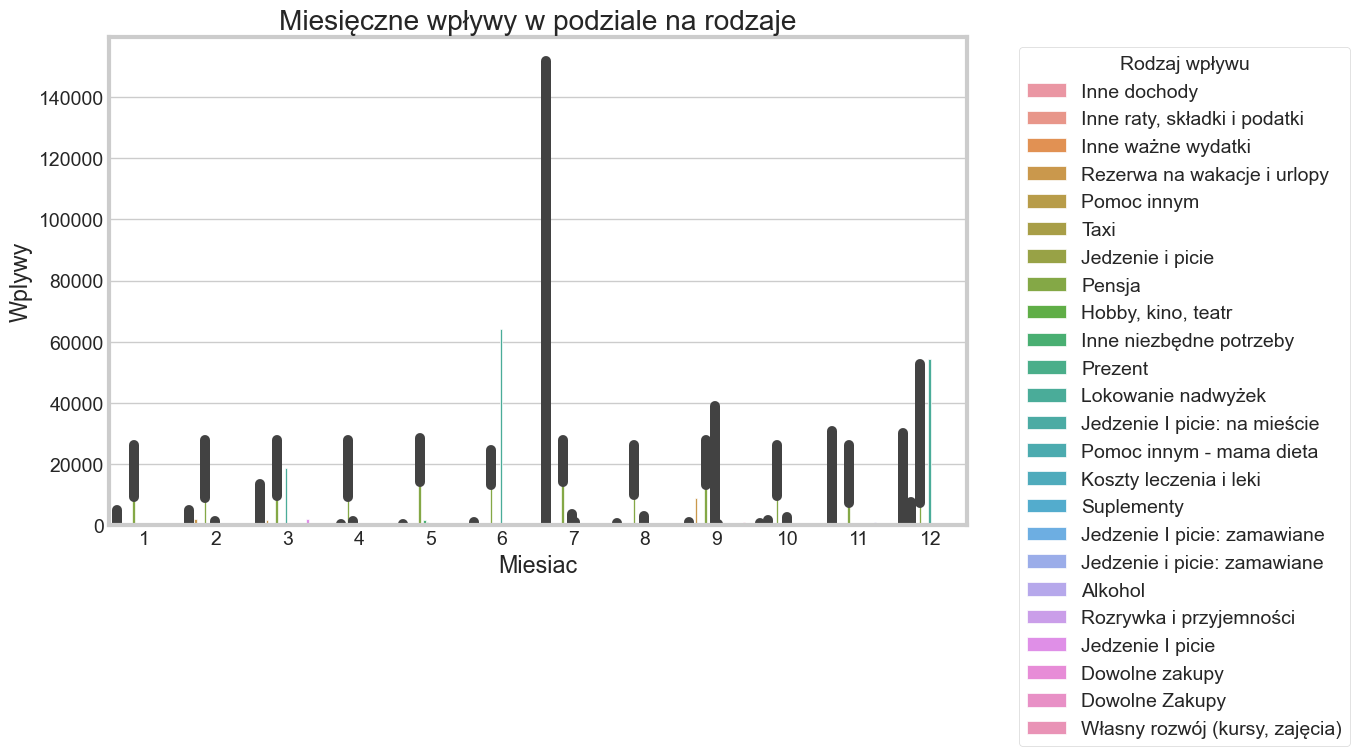

In [14]:

# 5. Tworzenie wykresów
sns.set_style("whitegrid")

# Wykres miesięcznych wpływów
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_income_by_type, x='Miesiac', y='Wplywy', hue='Kategoria')
plt.title('Miesięczne wpływy w podziale na rodzaje')
plt.legend(title='Rodzaj wpływu', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [15]:
monthly_data

,Rok,Miesiac,Rodzaj,Kategoria,Suma
0,1900,1,Debit,None,NaN
1,2019,11,Debit,Alkohol,-120.86
2,2019,11,Debit,Czynsz za mieszkanie,-517.74
3,2019,11,Debit,Dowolne zakupy,-0.45
4,2019,11,Debit,"Higiena, kosmetyki, fryzjer",-6.99
...,...,...,...,...,...
1052,2023,9,Debit,Rozrywka i przyjemności,-60.00
1053,2023,9,Debit,Transport,-6.80
1054,2023,9,Debit,Wspólny rachunek - Ada,-9565.23
1055,2023,9,Credit,"Własny rozwój (kursy, zajęcia)",1063.98


In [16]:
monthly_data[(monthly_data['Rok'] == 2023) & 
        (monthly_data['Miesiac'] == 9)]

,Rok,Miesiac,Rodzaj,Kategoria,Suma
1040,2023,9,Debit,Dowolne Zakupy,-113.84
1041,2023,9,Debit,"Higiena, kosmetyki, fryzjer",-472.90
1042,2023,9,Credit,Inne dochody,1292.80
1043,2023,9,Debit,Inne niezbędne potrzeby,-231.40
1044,2023,9,Debit,"Inne raty, składki i podatki",-10496.11
1045,2023,9,Debit,Jedzenie I picie: na mieście,-40.00
1046,2023,9,Debit,Jedzenie I picie: niezdrowe,-16.99
1047,2023,9,Credit,Lokowanie nadwyżek,39098.00
1048,2023,9,Debit,Lokowanie nadwyżek,-39098.00
1049,2023,9,Credit,Pensja,29319.07


In [17]:
# https://www.google.com/search?client=firefox-b-d&q=vs+code+interactive+plots+in+python#ip=1

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

def final_plot_with_larger_table(years, months, rodzaje):
    # Filtrujemy dane według wybranych lat, miesięcy i rodzajów transakcji
    data_in = monthly_data[
        monthly_data['Rok'].isin(years) & 
        monthly_data['Miesiac'].isin(months) & 
        monthly_data['Rodzaj'].isin(rodzaje)
    ].sort_values('Suma')  # Sortowanie słupków od najmniejszego do największego
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=data_in, x='Miesiac', y='Suma', hue='Kategoria', order=data_in['Miesiac'].unique())
    
    # Dodajemy etykiety do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                    ha='center', va='center', 
                    xytext=(0, -10), 
                    textcoords='offset points')
    
    plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
    plt.legend(title='Kategoria', bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=3)
    plt.tight_layout()
    
    # Dodanie większej tabeli pod wykresem
    sorted_data = data_in.sort_values('Suma', ascending=True)
    sorted_data['Suma'] = sorted_data['Suma'].round(2)
    plt.table(cellText=sorted_data[['Kategoria', 'Suma']].values,
              colLabels=['Kategoria', 'Suma'],
              cellLoc = 'center', 
              loc='bottom',
              bbox=[0, -0.7, 1, 0.5])
    
    plt.show()

available_years = sorted(monthly_data['Rok'].unique())
available_years.remove(1900)
available_months = sorted(monthly_data['Miesiac'].unique())
available_rodzaje = sorted(monthly_data['Rodzaj'].unique())

default_year = max(available_years)
default_rodzaj = "Debit"
default_month = max(monthly_data[monthly_data['Rok']==default_year]["Miesiac"])
# Uaktualnienie widgetu z wielokrotnym wyborem wartości
widgets.interact(
    final_plot_with_larger_table, 
    years=widgets.SelectMultiple(options=available_years, description='Rok:', value=(default_year,)), 
    months=widgets.SelectMultiple(options=available_months, description='Miesiąc:', value=(default_month,)),
    rodzaje=widgets.SelectMultiple(options=available_rodzaje, description='Rodzaj:', value=(default_rodzaj,))
)


interactive(children=(SelectMultiple(description='Rok:', index=(4,), options=(2019, 2020, 2021, 2022, 2023), v…

<function __main__.final_plot_with_larger_table(years, months, rodzaje)>

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

# Zakładam, że wcześniej zdefiniowałeś monthly_data
# monthly_data = ...

def plot_with_time_range_updated(categories, last_n_months, rodzaj):
    # Pobieranie najnowszej dostępnej daty
    latest_year = max(monthly_data['Rok'])
    latest_month = max(monthly_data[monthly_data['Rok'] == latest_year]["Miesiac"])
    
    # Określenie zakresu daty na podstawie last_n_months
    end_month = latest_month
    end_year = latest_year
    
    start_month = latest_month - last_n_months + 1
    start_year = latest_year
    while start_month <= 0:
        start_month += 12
        start_year -= 1

    # Filtrujemy dane według wybranego zakresu czasu, rodzaju i kategorii
    filtered_data = monthly_data[
        ((monthly_data['Rok'] == start_year) & (monthly_data['Miesiac'] >= start_month) |
         (monthly_data['Rok'] == end_year) & (monthly_data['Miesiac'] <= end_month)) &
        (monthly_data['Rodzaj'].isin(rodzaj)) &
        (monthly_data['Kategoria'].isin(categories))
    ]

    # Sumowanie danych dla wybranych kategorii
    summed_data = filtered_data.groupby(['Rok', 'Miesiac']).agg({'Suma': 'sum'}).reset_index()
    
    # Tworzenie kolumny z listą kategorii dla tabeli
    category_list = filtered_data.groupby(['Rok', 'Miesiac'])['Kategoria'].apply(list).apply(lambda x: ', '.join(x)).reset_index()
    summed_data['Kategoria'] = category_list['Kategoria']
    
    plt.figure(figsize=(15, 8))
    
    # Tworzenie wykresu słupkowego
    ax = sns.barplot(data=summed_data, x='Miesiac', y='Suma')
    
    # Dodawanie etykiet do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                    ha='center', va='center', 
                    xytext=(0, -10), 
                    textcoords='offset points')
    
    plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
    plt.tight_layout()
    
    # Dodawanie tabeli pod wykresem
    sorted_data = summed_data.sort_values(['Rok', 'Miesiac'], ascending=True)
    sorted_data['Suma'] = sorted_data['Suma'].round(2)
    plt.table(cellText=sorted_data[['Rok', 'Miesiac', 'Kategoria', 'Suma']].values,
              colLabels=['Rok', 'Miesiac', 'Kategoria', 'Suma'],
              cellLoc = 'center', 
              loc='bottom',
              bbox=[0, -0.7, 1, 0.5])
    
    plt.show()

available_categories = sorted(list(set(monthly_data['Kategoria'].unique())))
available_types = sorted(list(set(monthly_data['Rodzaj'].unique())))
default_rodzaj = ("Debit",)
default_categories = ("Jedzenie i picie",)

# Uruchamiam interaktywną wizualizację
widgets.interact(
    plot_with_time_range_updated, 
    categories=widgets.SelectMultiple(options=available_categories, description='Kategoria:', value=default_categories), 
    last_n_months=widgets.Dropdown(options=[3, 6, 9, 12, 18, 24], description='Ostatnie miesiące:', value=6),
    rodzaj=widgets.SelectMultiple(options=available_types, description='Rodzaj:', value=default_rodzaj)
)


<Figure size 1500x800 with 0 Axes>

interactive(children=(SelectMultiple(description='Kategoria:', index=(16,), options=('Alkohol', 'Bieżące raty …

<function __main__.plot_with_time_range_updated(categories, last_n_months, rodzaj)>

In [ ]:
available_categories = sorted(monthly_data['Kategoria'].unique())

TypeError: '<' not supported between instances of 'str' and 'NoneType'

C:\Users\tgusc\AppData\Local\Temp\ipykernel_33264\3593251820.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


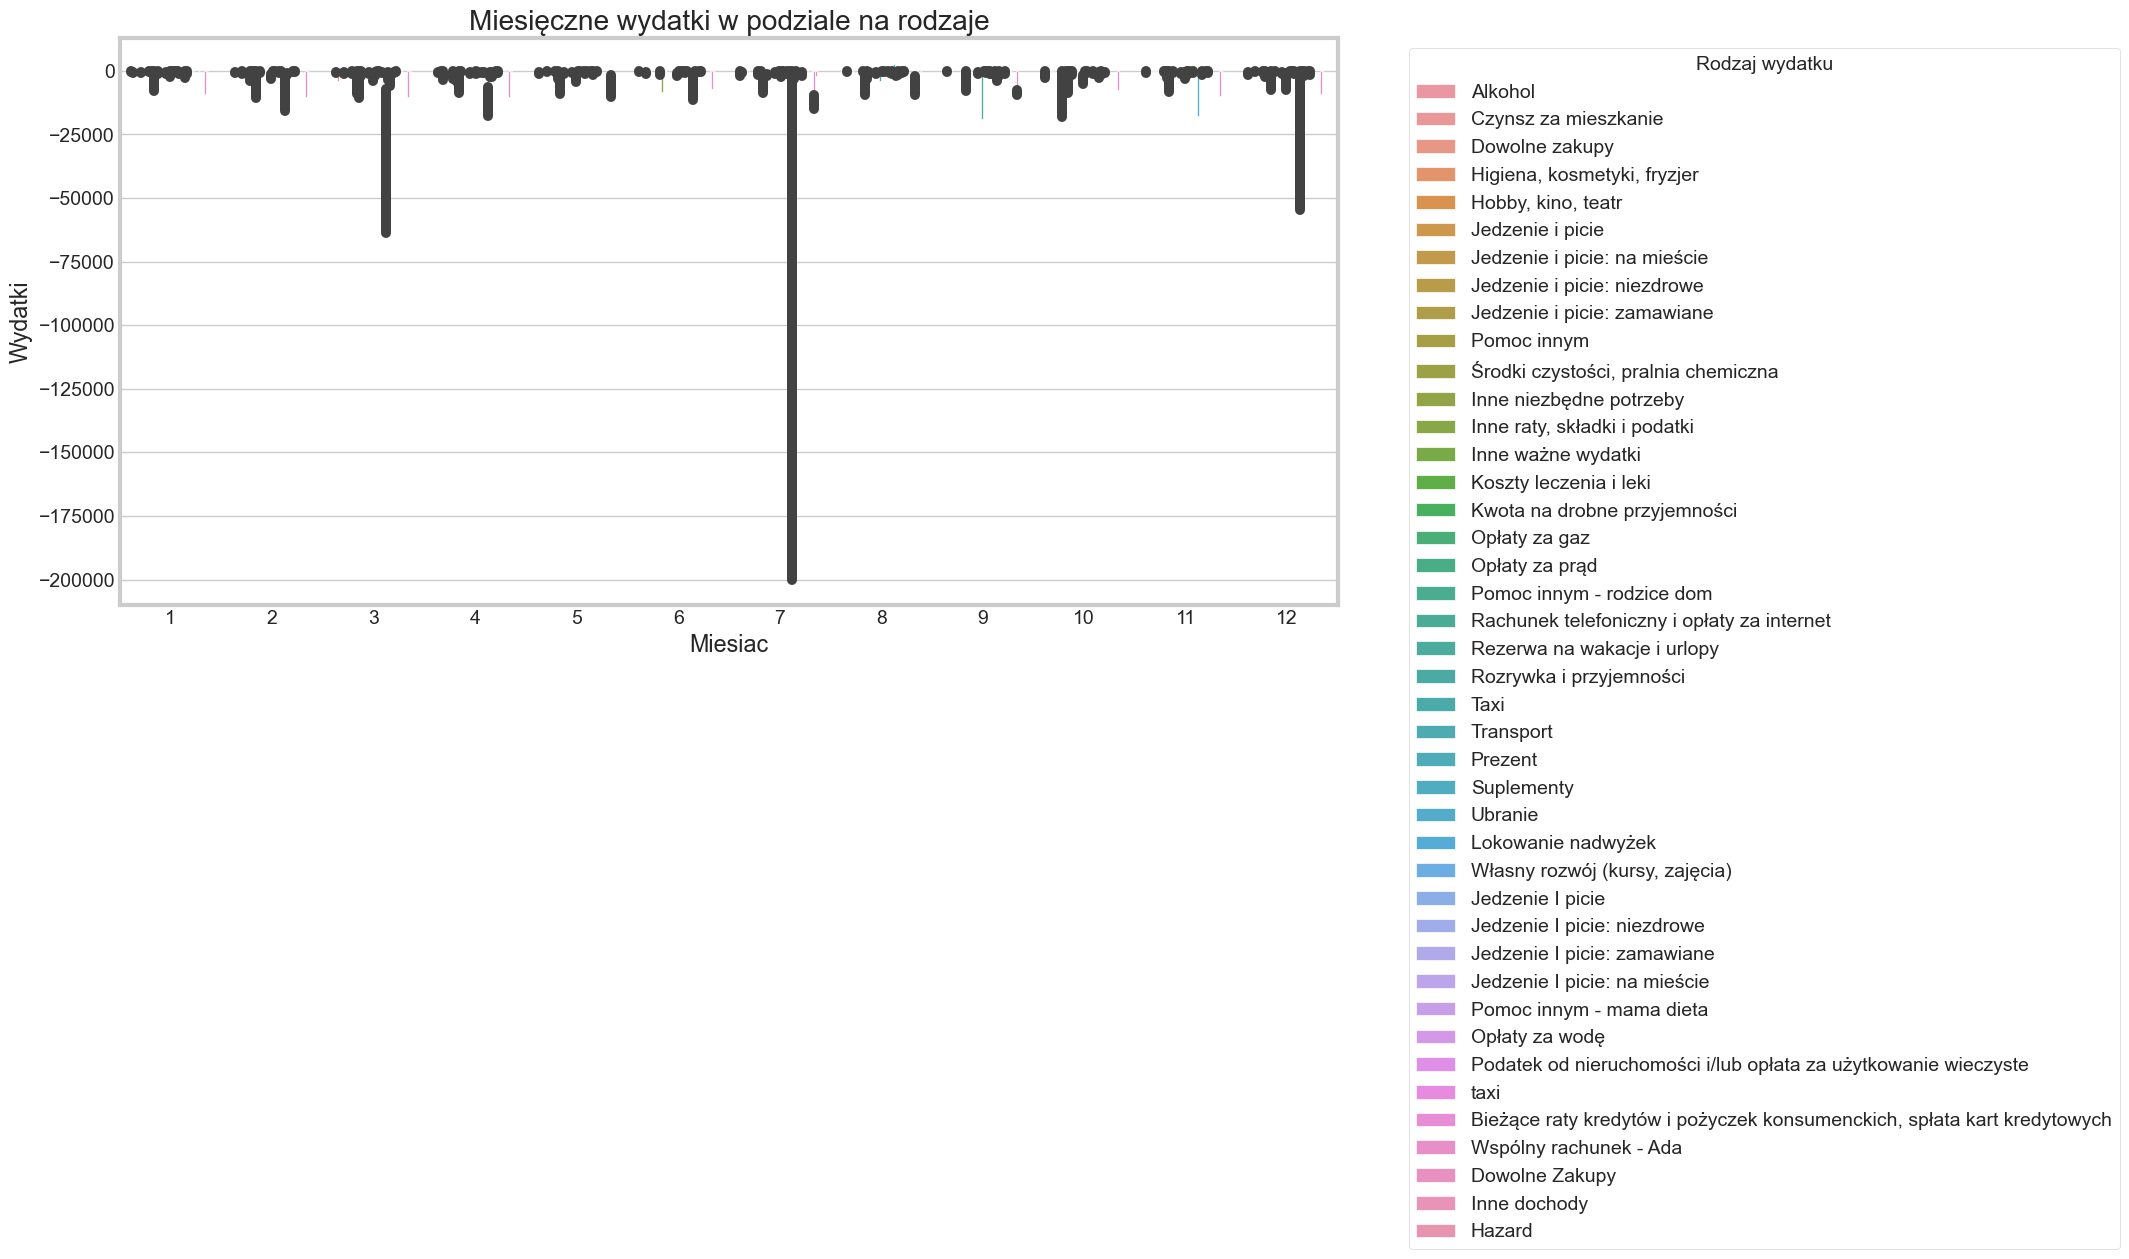

In [ ]:
# Wykres miesięcznych wydatków
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_expenses_by_type, x='Miesiac', y='Wydatki', hue='Kategoria')
plt.title('Miesięczne wydatki w podziale na rodzaje')
plt.legend(title='Rodzaj wydatku', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

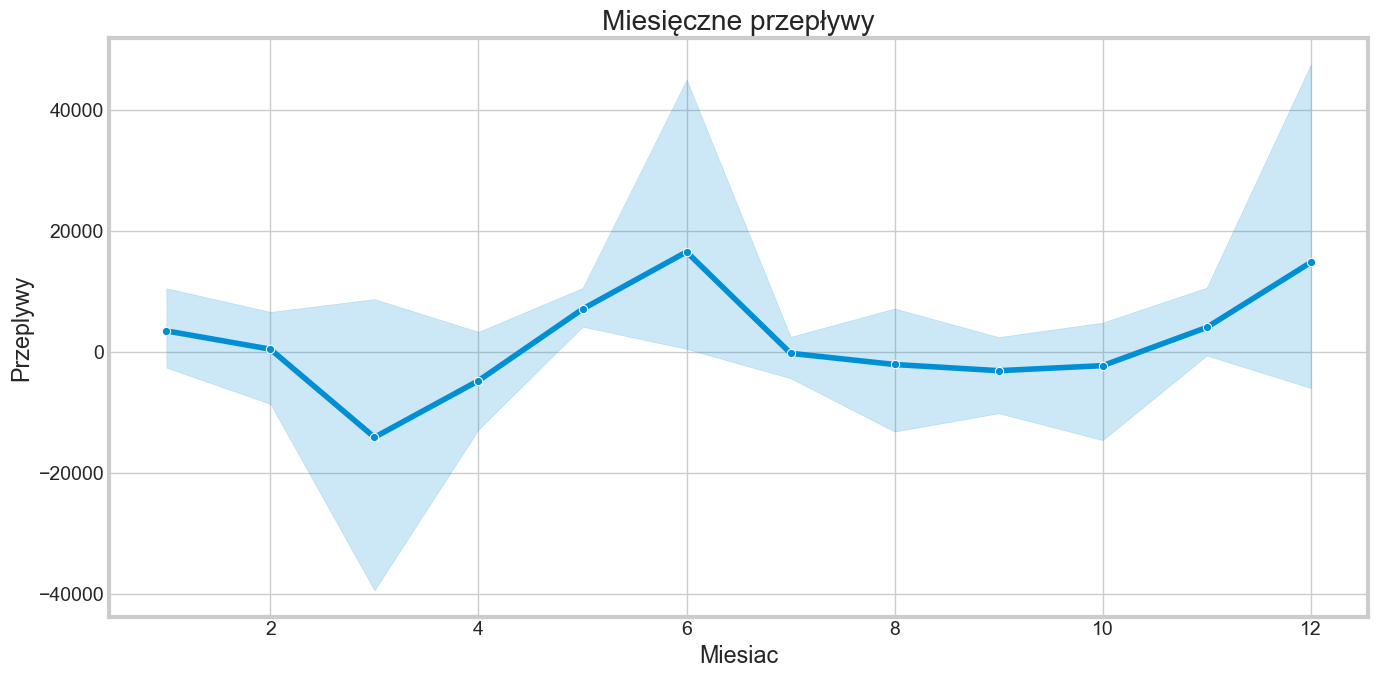

In [ ]:
# Wykres miesięcznych przepływów
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_flow, x='Miesiac', y='Przeplywy', marker="o")
plt.title('Miesięczne przepływy')
plt.tight_layout()
plt.show()


In [ ]:
# Stworzenie lokalnej bazy danych SQLite
conn = sqlite3.connect('transactions_db_temp.sqlite')
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Przygotowanie agregacji danych
query_monthly_expenses = """
SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki 
FROM transactions WHERE Rodzaj = 'Debit' 
GROUP BY Rok, Miesiac, Kategoria
"""

monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Poprawione obliczenie procentowego udziału kategorii w miesięcznych wydatkach
monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# Tworzenie monthly_expenses_structure
cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].sum().reset_index()
cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Wydatki': 'Suma_Wydatkow'})
monthly_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
monthly_expenses_structure['Procent_Struktury'] = monthly_expenses_structure['Wydatki'] / monthly_expenses_structure['Suma_Wydatkow'] * 100

monthly_expenses_structure.head(10)

In [ ]:

# Wykres analizy miesięcznej struktury wydatków
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_expenses_structure, x='Miesiac', y='Procent', hue='Kategoria')
plt.title('Analiza miesięcznej struktury wydatków')
plt.legend(title='Rodzaj wydatku', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'monthly_expenses_structure' is not defined

<Figure size 1400x700 with 0 Axes>

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Zaimportowanie pliku Excel do DataFrame
df = pd.read_excel('/path/to/your/excel/file.xlsx')  # Zmodyfikuj ścieżkę do pliku

# 2. Stworzenie lokalnej bazy danych SQLite
conn = sqlite3.connect('transactions_db.sqlite')
df.to_sql('transactions', conn, if_exists='replace', index=False)
conn.commit()

# 3. Przygotowanie agregacji danych
# Miesięczne wpływy
query_monthly_income = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wplywy FROM transactions WHERE Rodzaj = 'Credit' GROUP BY Rok, Miesiac, Kategoria"
monthly_income_by_type = pd.read_sql(query_monthly_income, conn)

# Miesięczne wydatki
query_monthly_expenses = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki FROM transactions WHERE Rodzaj = 'Debit' GROUP BY Rok, Miesiac, Kategoria"
monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Miesięczne przepływy
query_monthly_flow = "SELECT Rok, Miesiac, SUM(Case When Rodzaj = 'Credit' THEN Cena ELSE 0 END) as Wplywy, SUM(Case When Rodzaj = 'Debit' THEN Cena ELSE 0 END) as Wydatki FROM transactions GROUP BY Rok, Miesiac"
monthly_flow = pd.read_sql(query_monthly_flow, conn)

# Analiza miesięcznej struktury wydatków
monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].apply(lambda x: x / x.sum() * 100)

# 4. Przygotowanie danych kumulatywnych
# Kumulacyjne wpływy
monthly_income_by_type['Kumulacyjne_Wplywy'] = monthly_income_by_type.groupby(['Rok', 'Kategoria'])['Wplywy'].cumsum()

# Kumulacyjne wydatki
monthly_expenses_by_type['Kumulacyjne_Wydatki'] = monthly_expenses_by_type.groupby(['Rok', 'Kategoria'])['Wydatki'].cumsum()

# Kumulacyjne przepływy
monthly_flow['Kumulacyjne_Wplywy'] = monthly_flow.groupby('Rok')['Wplywy'].cumsum()
monthly_flow['Kumulacyjne_Wydatki'] = monthly_flow.groupby('Rok')['Wydatki'].cumsum()
monthly_flow['Kumulacyjne_Przeplywy'] = monthly_flow['Kumulacyjne_Wplywy'] + monthly_flow['Kumulacyjne_Wydatki']

# Kumulacyjna analiza struktury wydatków
cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Kumulacyjne_Wydatki'].sum().reset_index()
cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Kumulacyjne_Wydatki': 'Suma_Kumulacyjnych_Wydatkow'})
cumulative_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
cumulative_expenses_structure['Procent_Kumulacyjny'] = cumulative_expenses_structure['Kumulacyjne_Wydatki'] / cumulative_expenses_structure['Suma_Kumulacyjnych_Wydatkow'] 

100

# 5. Tworzenie wykresów
sns.set_style("whitegrid")



# Wykres miesięcznych wydatków
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_expenses_by_type, x='Miesiac', y='Wydatki', hue='Kategoria')
plt.title('Miesięczne wydatki w podziale na rodzaje')
plt.legend(title='Rodzaj wydatku', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Przykładowy budżet i porównanie z rzeczywistymi wydatkami
budget = {
    1: 10000,
    2: 9500,
    3: 10500,
    # ... i tak dalej dla kolejnych miesięcy
}
monthly_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].sum().reset_index()
monthly_expenses_sum['Budget'] = monthly_expenses_sum['Miesiac'].map(budget)
monthly_expenses_sum['Difference'] = monthly_expenses_sum['Budget'] + monthly_expenses_sum['Wydatki']
monthly_expenses_sum['Over_Budget'] = monthly_expenses_sum['Difference']  < 0